In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn.functional as F
from torch import nn, optim
import torchvision

plt.style.use('seaborn-whitegrid')

In [2]:
def dataset(file):
    current_datafile = open(file, 'r')
    current_dataset = current_datafile.readlines()
    current_datafile.close()

    datasets = np.zeros([len(current_dataset), 1025])
    indices = np.linspace(0, len(current_dataset) - 1, len(current_dataset), dtype = np.int64)
    np.random.shuffle(indices)
    for i in indices:
#         print(i)
        example = current_dataset[i].split(',')
        
        labels = np.asarray(example[0], dtype = np.float32)
        images = np.asarray(example[1:], dtype=np.float32) / 255   
        example = np.hstack([labels, images])
        
        datasets[i] = example
    return datasets


In [3]:
trainloader = th.utils.data.DataLoader(dataset('train.csv'), shuffle = True, batch_size = 32)
testloader = th.utils.data.DataLoader(dataset('train.csv'), shuffle = True, batch_size = 32)

In [4]:
x = th.ones([1, 2])
# print(x)
a = th.Tensor([2, 2])

ff = nn.Linear(2, 1, False)
ff.weight.data = x


print(ff(a))



tensor([4.], grad_fn=<SqueezeBackward3>)


In [5]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 16, 3)
        self.conv3 = nn.Conv2d(16, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 10)
#         self.fc1.weight.data = th.ones()
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.drop(self.pool(F.relu(self.conv1(x))))
        x = self.drop(self.pool(F.relu(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
#         print(x.shape)
        x = x.view(-1, 32)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))

        return x

example = next(iter(trainloader))
label = example[0][0]
example = example[0][1:].float()
example = example.reshape(1, 1, 32, 32)
    
model = Net()

print(label, model(example))


tensor(2., dtype=torch.float64) tensor([[0.0000, 0.0000, 0.1856, 0.1332, 0.1429, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2262]], grad_fn=<ReluBackward0>)


In [6]:
optimizer = optim.SGD(model.parameters(), weight_decay=1e-6, lr=0.01, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()


In [7]:
epochs = 30
train_losses, test_losses = [], []
train_accuracy = []
for epoch in range(epochs):
    running_loss = 0
    for example in trainloader:
        label = th.Tensor([example[0][0].float()]).long()
        image = th.reshape(example[0][1:].float(), (1, 1, 32, 32))
        
        logps = model(image).reshape(1, 10)  
        optimizer.zero_grad()
        loss = criterion(logps, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    else:
        model.eval()
        test_loss = 0
        accuracy = 0

        with th.no_grad():
            for example in testloader:
                label = th.Tensor([example[0][0].float()]).long()
                image = th.reshape(example[0][1:].float(), (1, 1, 32, 32))

                logps = model(image).reshape(1, 10) 
                test_loss += criterion(logps, label.long())
    #                 print(label, logps)
                ps = th.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == label.view(*top_class.shape)
                accuracy += th.mean(equals.type(th.FloatTensor))

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            train_accuracy.append(accuracy / len(testloader))

            print("Epoch: {}/{}.. ".format(epoch + 1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}%".format(accuracy/len(testloader) * 100))


Epoch: 1/30..  Training Loss: 2.277..  Test Loss: 2.303..  Test Accuracy: 9.398%
Epoch: 2/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 11.090%
Epoch: 3/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 9.586%
Epoch: 4/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 10.150%
Epoch: 5/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 8.271%
Epoch: 6/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 13.158%
Epoch: 7/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 9.211%
Epoch: 8/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 11.278%
Epoch: 9/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 10.338%
Epoch: 10/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 8.271%
Epoch: 11/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 9.586%
Epoch: 12/30..  Training Loss: 2.303..  Test Loss: 2.303..  Test Accuracy: 7.331%
Epoch: 13/30..  Trai

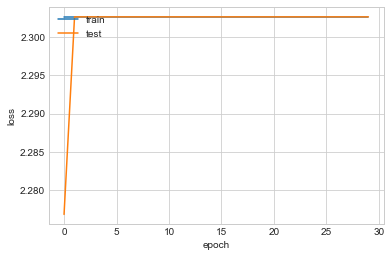

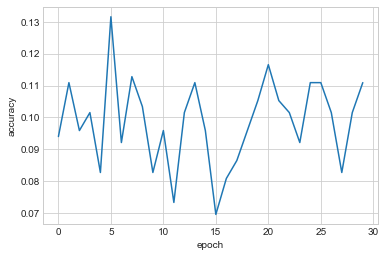

In [8]:
plt.plot(test_losses)
plt.plot(train_losses)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(train_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

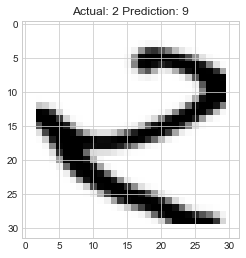

In [9]:
example = next(iter(testloader))

label = example[0][0]
image = th.reshape(example[0][1:].float(), (1, 1, 32, 32))
# image = image.view(image.shape[0], -1)
prediction = model(image)

pred_label = th.argmax(prediction)

title = f"Actual: {int(label)} Prediction: {pred_label}"

plt.imshow(image.reshape(32, 32))
plt.title(title)
plt.show()

In [10]:
th.save(model, 'dcr.pth')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
model = th.load('dcr.pth')


tensor([9])


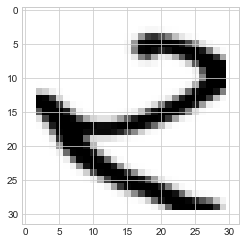

In [12]:
print(th.argmax(model(image), 1))
plt.imshow(image.reshape(32, 32))